In [10]:
#-*- coding: utf-8 -*-
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cPickle

from PIL import Image

import tensorflow.python.platform
from keras.preprocessing import sequence
from collections import Counter

import skimage
import skimage.io

from tokenizer.ptbtokenizer import PTBTokenizer
from cider.cider import Cider
from cider.cider_scorer import CiderScorer

class Caption_Generator():
    def init_weight(self, dim_in, dim_out, name=None, stddev=1.0):
        return tf.Variable(tf.truncated_normal([dim_in, dim_out], stddev=stddev/math.sqrt(float(dim_in))), name=name)

    def init_bias(self, dim_out, name=None):
        return tf.Variable(tf.zeros([dim_out]), name=name)

    def __init__(self, dim_image, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, bias_init_vector=None):

        self.dim_image = np.int(dim_image)
        self.dim_embed = np.int(dim_embed)
        self.dim_hidden = np.int(dim_hidden)
        self.batch_size = np.int(batch_size)
        self.n_lstm_steps = np.int(n_lstm_steps)
        self.n_words = np.int(n_words)

        with tf.device("/cpu:0"):
            self.Wemb = tf.Variable(tf.random_uniform([n_words, dim_embed], -0.1, 0.1), name='Wemb')

        self.bemb = self.init_bias(dim_embed, name='bemb')

        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden, state_is_tuple=False)

        #self.encode_img_W = self.init_weight(dim_image, dim_hidden, name='encode_img_W')
        self.encode_img_W = tf.Variable(tf.random_uniform([dim_image, dim_hidden], -0.1, 0.1), name='encode_img_W')
        self.encode_img_b = self.init_bias(dim_hidden, name='encode_img_b')

        self.embed_word_W = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='embed_word_W')

        if bias_init_vector is not None:
            self.embed_word_b = tf.Variable(bias_init_vector.astype(np.float32), name='embed_word_b')
        else:
            self.embed_word_b = self.init_bias(n_words, name='embed_word_b')

    def build_model(self):

        image = tf.placeholder(tf.float32, [self.batch_size, self.dim_image])
        sentence = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])

        image_emb = tf.matmul(image, self.encode_img_W) + self.encode_img_b # (batch_size, dim_hidden)

        state = tf.zeros([self.batch_size, self.lstm.state_size])

        loss = 0.0
        with tf.variable_scope("RNN"):
            for i in range(self.n_lstm_steps): # maxlen + 1
                if i == 0:
                    current_emb = image_emb
                else:
                    with tf.device("/cpu:0"):
                        current_emb = tf.nn.embedding_lookup(self.Wemb, sentence[:,i-1]) + self.bemb

                if i > 0 : tf.get_variable_scope().reuse_variables()

                output, state = self.lstm(current_emb, state) # (batch_size, dim_hidden)

                if i > 0: # 이미지 다음 바로 나오는건 #START# 임. 이건 무시.
                    labels = tf.expand_dims(sentence[:, i], 1) # (batch_size)
                    indices = tf.expand_dims(tf.range(0, self.batch_size, 1), 1)
                    concated = tf.concat([indices, labels], 1)
                    onehot_labels = tf.sparse_to_dense(
                            concated, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0) # (batch_size, n_words)

                    logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b # (batch_size, n_words)
                    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words, labels=onehot_labels)
                    cross_entropy = cross_entropy * mask[:,i]#tf.expand_dims(mask, 1)

                    current_loss = tf.reduce_sum(cross_entropy)
                    loss = loss + current_loss

            loss = loss / tf.reduce_sum(mask[:,1:])
            return loss, image, sentence, mask

    def build_generator(self, maxlen):
        image = tf.placeholder(tf.float32, [1, self.dim_image])
        image_emb = tf.matmul(image, self.encode_img_W) + self.encode_img_b

        state = tf.zeros([1, self.lstm.state_size])
        #last_word = image_emb # 첫 단어 대신 이미지
        generated_words = []

        with tf.variable_scope("RNN"):
            output, state = self.lstm(image_emb, state)
            last_word = tf.nn.embedding_lookup(self.Wemb, [0]) + self.bemb

            for i in range(maxlen):
                tf.get_variable_scope().reuse_variables()

                output, state = self.lstm(last_word, state)

                logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b
                max_prob_word = tf.argmax(logit_words, 1)

                with tf.device("/cpu:0"):
                    last_word = tf.nn.embedding_lookup(self.Wemb, max_prob_word)

                last_word += self.bemb

                generated_words.append(max_prob_word)

        return image, generated_words

def get_caption_data(train_anno_path, train_feat_path):
     feats = np.load(train_feat_path)
     annotations = np.load(train_anno_path)
#     captions = annotations['caption'].values

     return feats, annotations

def preProBuildWordVocab(sentence_iterator, word_count_threshold=30): # borrowed this function from NeuralTalk
    print 'preprocessing word counts and creating vocab based on word count threshold %d' % (word_count_threshold, )
    word_counts = {}
    nsents = 0
    for sent in sentence_iterator:
      nsents += 1
      for w in sent.lower().split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print 'filtered words from %d to %d' % (len(word_counts), len(vocab))

    ixtoword = {}
    ixtoword[0] = '.'  # period at the end of the sentence. make first dimension be end token
    wordtoix = {}
    wordtoix['#START#'] = 0 # make first vector be the start token
    ix = 1
    for w in vocab:
      wordtoix[w] = ix
      ixtoword[ix] = w
      ix += 1

    word_counts['.'] = nsents
    bias_init_vector = np.array([1.0*word_counts[ixtoword[i]] for i in ixtoword])
    bias_init_vector /= np.sum(bias_init_vector) # normalize to frequencies
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) # shift to nice numeric range
    return wordtoix, ixtoword, bias_init_vector

def crop_image(x, target_height=227, target_width=227, as_float=True):
    #image = skimage.img_as_float(skimage.io.imread(x)).astype(np.float32)
    image = skimage.io.imread(x)
    if as_float:
        image = skimage.img_as_float(image).astype(np.float32)

    if len(image.shape) == 2:
        image = np.tile(image[:,:,None], 3)
    elif len(image.shape) == 4:
        image = image[:,:,:,0]

    height, width, rgb = image.shape
    if width == height:
        resized_image = cv2.resize(image, (target_height,target_width))

    elif height < width:
        resized_image = cv2.resize(image, (int(width * float(target_height)/height), target_width))
        cropping_length = int((resized_image.shape[1] - target_height) / 2)
        resized_image = resized_image[:,cropping_length:resized_image.shape[1] - cropping_length]

    else:
        resized_image = cv2.resize(image, (target_height, int(height * float(target_width) / width)))
        cropping_length = int((resized_image.shape[0] - target_width) / 2)
        resized_image = resized_image[cropping_length:resized_image.shape[0] - cropping_length,:]

    return cv2.resize(resized_image, (target_height, target_width))

################### 학습 관련 Parameters #####################

dim_embed = 256
dim_hidden = 256
dim_image = 4096
batch_size = 128

#learning_rate = 0.001
n_epochs = 10
###############################################################
#################### 잡다한 Parameters ########################
model_path = './models'
vgg_path = './data/vgg16.tfmodel'
data_path = './data'
train_feat_path = './data/train_feat.npy'
test_feat_path  = './data/test_feat.npy'
train_anno_path = './data/train_caption.npy'
test_anno_path  = './data/test_caption.npy'
annotation_path = os.path.join(data_path, 'results_20130124.token')
################################################################


def train():

    learning_rate = 0.001
    momentum = 0.9
    feats, captions = get_caption_data(train_anno_path, train_feat_path)
    wordtoix, ixtoword, bias_init_vector = preProBuildWordVocab(captions)

    np.save('data/ixtoword', ixtoword)

    index = np.arange(len(feats))
    np.random.shuffle(index)

    feats = feats[index]
    captions = captions[index]

    sess = tf.InteractiveSession()
    n_words = len(wordtoix)
    maxlen = np.max( map(lambda x: len(x.split(' ')), captions) )
    caption_generator = Caption_Generator(
            dim_image=dim_image,
            dim_hidden=dim_hidden,
            dim_embed=dim_embed,
            batch_size=batch_size,
            n_lstm_steps=maxlen+2,
            n_words=n_words,
            bias_init_vector=bias_init_vector)

    loss, image, sentence, mask = caption_generator.build_model()

    saver = tf.train.Saver(max_to_keep=50)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    tf.initialize_all_variables().run()
    for epoch in range(n_epochs):
        #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        for start, end in zip( \
                range(0, len(feats), batch_size),
                range(batch_size, len(feats), batch_size)
                ):
            current_feats = feats[start:end]
            current_captions = captions[start:end]

            current_caption_ind = map(lambda cap: [wordtoix[word] for word in cap.lower().split(' ')[:-1] if word in wordtoix], current_captions)

            current_caption_matrix = sequence.pad_sequences(current_caption_ind, padding='post', maxlen=maxlen+1)
            current_caption_matrix = np.hstack( [np.full( (len(current_caption_matrix),1), 0), current_caption_matrix] ).astype(int)

            current_mask_matrix = np.zeros((current_caption_matrix.shape[0], current_caption_matrix.shape[1]))
            nonzeros = np.array( map(lambda x: (x != 0).sum()+2, current_caption_matrix ))
            #  +2 -> #START# and '.'

            for ind, row in enumerate(current_mask_matrix):
                row[:nonzeros[ind]] = 1

            _, loss_value = sess.run([train_op, loss], feed_dict={
                image: current_feats,
                sentence : current_caption_matrix,
                mask : current_mask_matrix
                })

            print "Current Cost: ", loss_value, ", Epoch: ", epoch, ", iteration: ", start, "/", len(feats) 

        print "Epoch ", epoch, " is done. Saving the model ... "
        saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch)
        learning_rate *= 0.95

def read_image(path):

     img = crop_image(path, target_height=224, target_width=224)
     if img.shape[2] == 4:
         img = img[:,:,:3]

     img = img[None, ...]
     return img

def evaluation(test_image_path='data/flickr30k', model_path='./models/model-10', maxlen=30):        
    ixtoword = np.load('./data/ixtoword.npy').tolist()
    n_words = len(ixtoword)
    
    filename = np.load('./data/test_file.npy')
    test_feat = np.load('./data/test_feat.npy')
    
    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    fc7_tf, generated_word = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)
    
    res = {}
    cnt = 0
    for i in range(0, len(test_feat)):
        image_feat = np.reshape(test_feat[i], (1, -1))
        image = filename[i]
        
        generated_word_index= sess.run(generated_word, feed_dict={fc7_tf:image_feat})
        generated_word_index = np.hstack(generated_word_index)

        generated_words = [ixtoword[x] for x in generated_word_index]
        punctuation = np.argmax(np.array(generated_words) == '.')+1
        
        generated_words = generated_words[:punctuation]
        generated_sentence = ' '.join(generated_words)
        
        if cnt % 50 == 0:
            PIL_image = Image.open(os.path.join(test_image_path, image))
            fig,ax=plt.subplots(1,1)
            ax.imshow(PIL_image)
            plt.show()
            
            print generated_sentence
        
        res[image] = [{}]
        res[image][0]['caption'] = generated_sentence
        res[image][0]['image_id'] = image
        
        cnt += 1
    
    gt_cap = np.load('./data/test_caption.npy')
    
    gts = {}
    
    cnt = 0
    for name in filename:
        gts[name] = [{}, {}, {}, {}, {}]
        for j in range(0, 5):
            gts[name][j]['caption'] = gt_cap[cnt]
            gts[name][j]['image_id'] = name
            cnt += 1
    
    tokenizer = PTBTokenizer()
    gts = tokenizer.tokenize(gts)
    res = tokenizer.tokenize(res)
    
    cider = Cider()
    score, scores = cider.compute_score(gts, res)
    
    print('Cider: %d' % score)
    print(scores)

def test_tf(test_image_path=None, model_path='./models/model-72', maxlen=30):
    with open(vgg_path) as f:
        fileContent = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent)

    images = tf.placeholder("float32", [1, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={"images":images})

    ixtoword = np.load('./data/ixtoword.npy').tolist()
    n_words = len(ixtoword)

    image_val = read_image(test_image_path)
    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    graph = tf.get_default_graph()
    fc7 = sess.run(graph.get_tensor_by_name("import/fc7_relu:0"), feed_dict={images:image_val})

    fc7_tf, generated_words = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    generated_word_index= sess.run(generated_words, feed_dict={fc7_tf:fc7})
    generated_word_index = np.hstack(generated_word_index)

    generated_words = [ixtoword[x] for x in generated_word_index]
    punctuation = np.argmax(np.array(generated_words) == '.')+1

    generated_words = generated_words[:punctuation]
    generated_sentence = ' '.join(generated_words)
    print generated_sentence


In [ ]:
train()

INFO:tensorflow:Restoring parameters from models/model-2


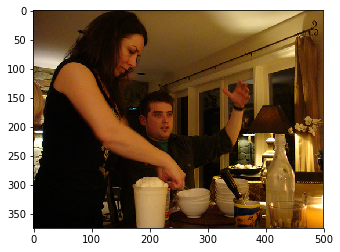

a woman is holding a baby in a .


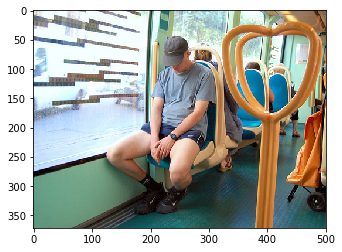

a young boy in a blue shirt and jeans is sitting on a wooden floor .


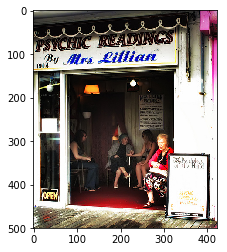

a woman in a white shirt and a white hat is standing in front of a store .


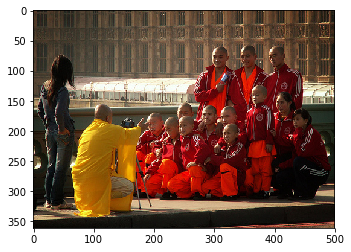

a group of people are standing in front of a crowd .


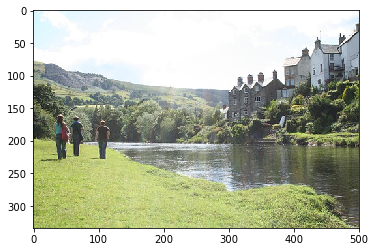

a man is walking on a bridge in the water .


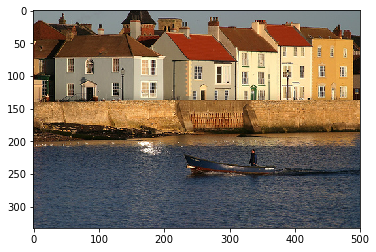

a man is fishing off of a pier into the water .


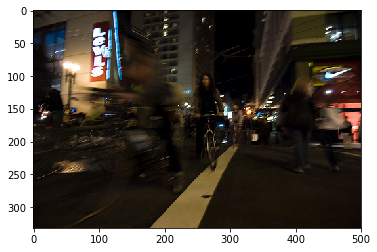

a man in a red shirt is walking down the street .


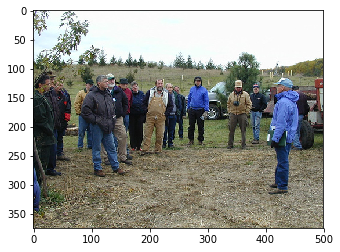

a group of people are standing in front of a large tree .


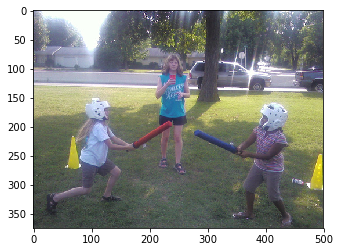

a little girl in a pink dress is running on a grassy field .


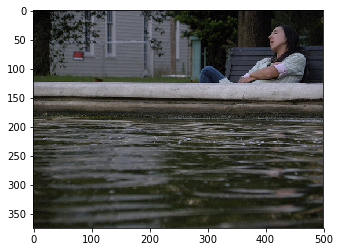

a woman in a blue shirt and a white skirt is sitting on a bench in front of a lake .


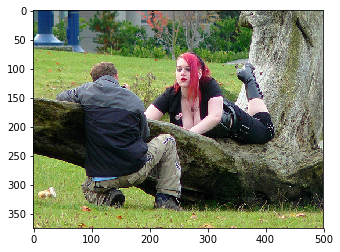

a man in a blue shirt and a woman in a white shirt are sitting on a rock .


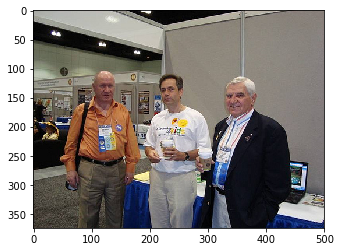

a group of people are standing in front of a building .


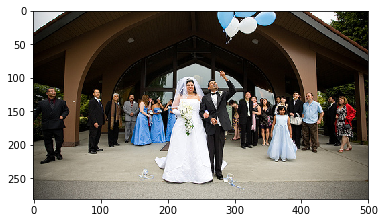

a group of people are standing in front of a building .


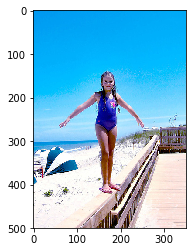

a woman in a white shirt is jumping in the air .


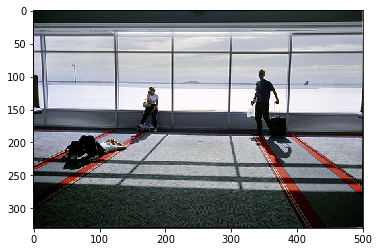

a man in a black shirt and jeans is sitting on a skateboard .


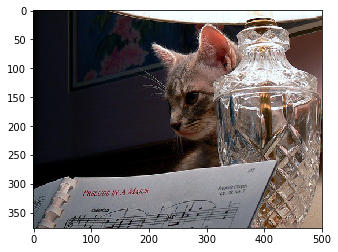

a woman is sitting in a chair with a white shirt and a black shirt .


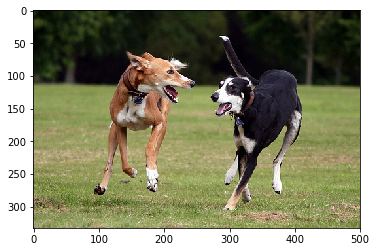

a black and white dog is running through a field .


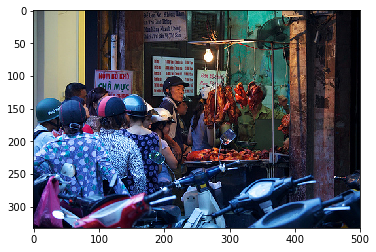

a man in a red shirt is standing on a street .


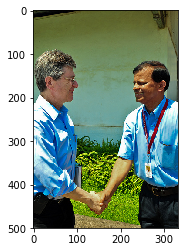

a man in a white shirt is holding a camera .


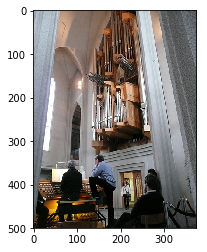

a woman is walking down the street .


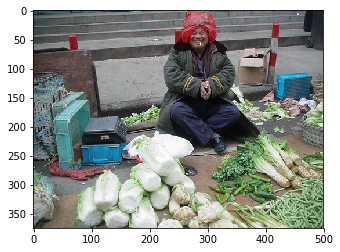

a man in a white shirt and a hat is sitting on a bench .


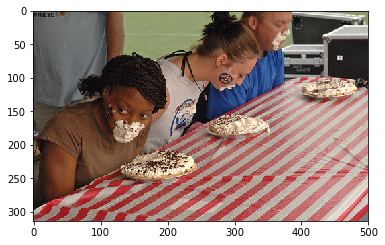

a woman in a white shirt is holding a baby in a .


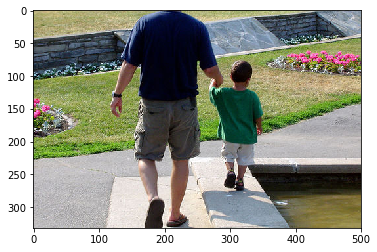

a young boy in a blue shirt and jeans is walking on a sidewalk .


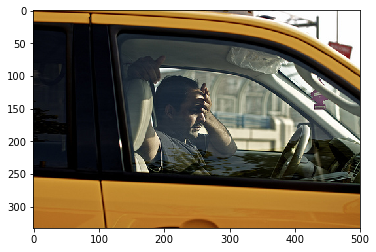

a man in a red shirt is sitting on a red couch .


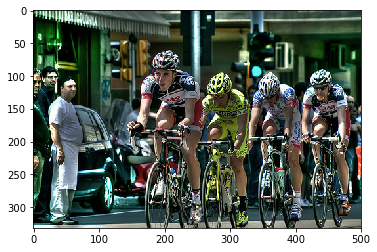

a man in a red shirt is riding a bicycle .


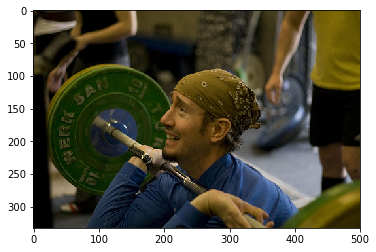

a man in a black shirt is playing a guitar .


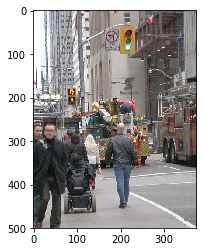

a man in a red shirt is walking down the street .


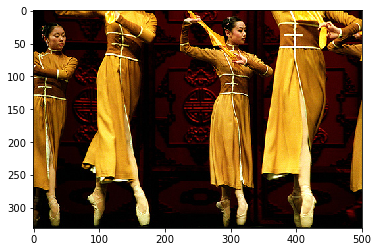

a man in a white shirt is holding a microphone .


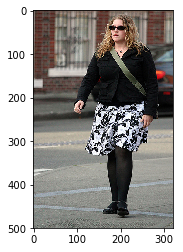

a woman in a black and white dress is walking down the street .


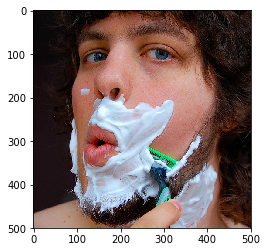

a woman in a white shirt is holding a large bubble .


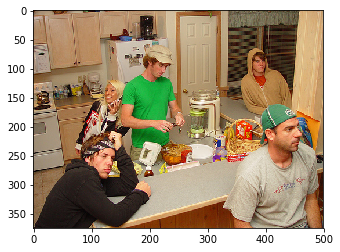

a man and a woman are sitting in a room with a table .


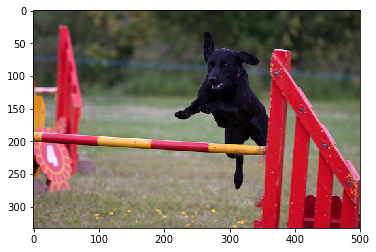

a dog is running through the grass .


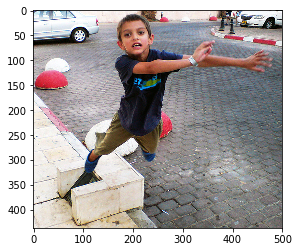

a young boy in a red shirt is climbing a wall .


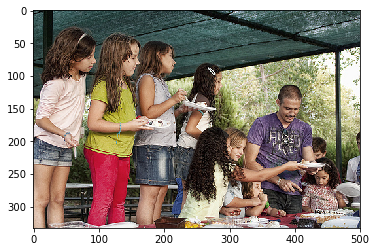

a woman in a white shirt is holding a tray of food .


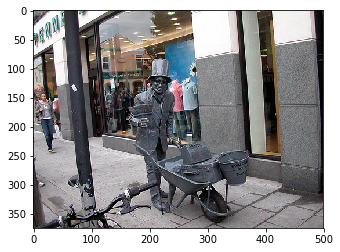

a man in a blue shirt and a woman in a white shirt are sitting on a bench .


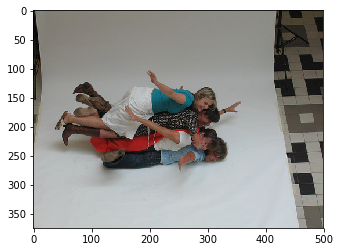

a woman is jumping over a hurdle .


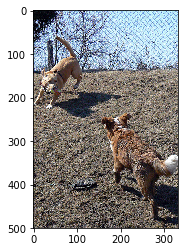

two dogs are running in the grass .


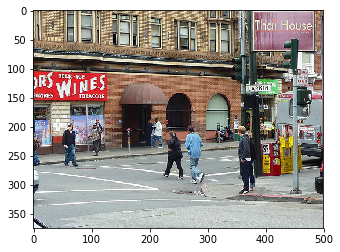

a man in a white shirt and a woman in a white shirt are walking down the street .


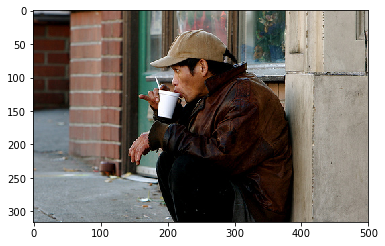

a man in a black shirt and jeans is standing in front of a building .


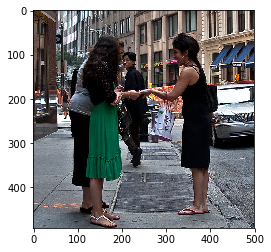

a woman in a black dress and a black skirt is walking down the street .


AssertionError: 

In [11]:
evaluation('data/flickr30k/', 'models/model-2')

In [2]:
gts = {1: [{'caption': 'A man with pierced ears is wearing glasses and an orange hat', 'id':1, 'image_id': 1}, 
           {'caption': 'A man with glasses is wearing a beer can crotched hat', 'id':6,'image_id': 1},
           {'caption': 'A man with gauges and glasses is wearing a Blitz hat', 'id':2,'image_id': 1}, 
           {'caption': 'A man in an orange hat starring at something', 'id':5,'image_id': 1},
           {'caption': 'A man wears an orange hat and glasses', 'id':3,'image_id': 1}]}
res = {1: [{'caption': 'A man wears an orange hat and glasses', 'id':4,'image_id': 1}]}
tokenizer = PTBTokenizer()
gts = tokenizer.tokenize(gts)
res = tokenizer.tokenize(res)

In [3]:

cider = Cider()
score, scores = cider.compute_score(gts, res)

AssertionError: 

In [ ]:
score

In [ ]:
gts

In [ ]:
res

In [4]:
scorer = CiderScorer(n = 4, sigma = 6.0)

In [5]:
scorer += (res[1][0], gts[1])

In [6]:
scorer.compute_doc_freq()

In [9]:
max(scorer.document_frequency.values())

5.0

In [ ]:
scorer.crefs

In [ ]:
scorer.ctest

In [ ]:
document_frequency = defaultdict(float)
for refs in scorer.crefs:
    for ngram in ([ngram for ref in refs for (ngram, count) in ref.iteritems()]):
        document_frequency[ngram] += 1

In [ ]:
from collections import defaultdict

In [ ]:
document_frequency